# 5.1 二维卷积层

In [43]:
import torch
from torch import nn 

def corr2d(X, K):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    h, w = K.shape
    X, K = X.float(), K.float()
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

In [44]:
X = torch.tensor([[5, 6, 2], [3, 4, 5], [6, 7, 8]])
K = torch.tensor([[0, 4], [8, 3]])
import time


In [45]:
%%time
corr2d(X,K)

Wall time: 0 ns


tensor([[ 60.,  55.],
        [ 85., 100.]])

In [54]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super(Conv2D, self).__init__()
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

## 5.1.3 检测物体的边缘


In [55]:
X = torch.ones(6, 8)
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [56]:
K = torch.tensor([[1, -1]])

In [57]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [58]:
# 构造一个核数组形状是(1, 2)的二维卷积层
conv2d = Conv2D(kernel_size=(1, 2))

step = 80
lr = 0.01
for i in range(step):
    Y_hat = conv2d(X)
    l = ((Y_hat - Y) ** 2).sum()
    l.backward()
    
    # 梯度下降
    conv2d.weight.data -= lr * conv2d.weight.grad
    conv2d.bias.data -= lr * conv2d.bias.grad
    
    # 梯度清0
    conv2d.weight.grad.fill_(0)
    conv2d.bias.grad.fill_(0)
    if (i + 1) % 5 == 0:
        print('Step %d, loss %.3f' % (i + 1, l.item()))

Step 5, loss 4.430
Step 10, loss 1.191
Step 15, loss 0.327
Step 20, loss 0.091
Step 25, loss 0.025
Step 30, loss 0.007
Step 35, loss 0.002
Step 40, loss 0.001
Step 45, loss 0.000
Step 50, loss 0.000
Step 55, loss 0.000
Step 60, loss 0.000
Step 65, loss 0.000
Step 70, loss 0.000
Step 75, loss 0.000
Step 80, loss 0.000


In [53]:
print("weight: ", conv2d.weight.data)
print("bias: ", conv2d.bias.data)

weight:  tensor([[ 1.0000, -1.0000]])
bias:  tensor([-1.9090e-08])


## 5.1.5 互相关运算和卷积运算
互相关运算就是卷积运算

# 5.2 填充和步幅
步幅为1 无填充时
输出形状为 （H - Kh +1，W - Kw +1）

填充Ph行和Pw列 步幅为1时
输出形状为 （H - Kh + Ph +1，W - Kw + Pw +1）
Ph = Kh - 1 时，会有原输入有相同的高和宽

当无填充， 步幅分别为 Sh 和 Sw时
(H-Kh +Ph +Sh)/Sh

# 5.3 多输入通道和多输出通道

In [48]:
import torch
from torch import nn
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

In [49]:
def corr2d_multi_in(X,K):
    # 沿着X和K的第零维分别计算再相加
    res = d2l.corr2d(X[0,:,:],K[0,:,:])
    for i in range(1,X.shape[0]):
        res += d2l.corr2d(X[i, :, :], K[i, :, :])
    return res

In [50]:
X = torch.tensor([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
                 [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = torch.tensor([[[0, 1], [2, 3]], [[1, 2], [3, 4]]])
corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [51]:
def corr2d_multi_in_out(X, K):
     # 对K的第0维遍历，每次同输⼊X做互相关计算。
    # 所有结果使⽤stack函数合并在⼀起
     return torch.stack([corr2d_multi_in(X, k) for k in K])

In [52]:
K = torch.stack([K, K + 1, K + 2])
K.shape

torch.Size([3, 2, 2, 2])

In [53]:
# 实现 1*1卷积层
def corr2d_multi_in_out_1x1(X, K):
    c_i,h,w = X.shape
    c_o = K.shape[0]
    X = X.view(c_i,h*w)   #flatten
    K = K.view(c_o,c_i)
    Y = torch.mm(K,X)  #全连接的矩阵乘法
    return Y.view(c_o,h,w)

In [54]:
X = torch.rand(3, 3, 3) 

K = torch.rand(2, 3, 1, 1)

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
print(Y1.shape)
(Y1 - Y2).norm().item() < 1e-6

torch.Size([2, 3, 3])


True

In [80]:
X = torch.arange(16, dtype=torch.float).view((1, 1, 4, 4))
X
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [84]:
X = torch.arange(16, dtype=torch.float).view((1, 1, 4, 4))
X = torch.cat((X, X + 1), dim=1) 
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [85]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# 5.5 卷积神经网络
卷积层块⾥的基本单位是卷积层后接最⼤池化层：卷积层⽤来识别图像⾥的空间模式，如线条和物体局部，之后的最⼤池化层则⽤来降低卷积层对位置的敏感性。卷积层块由两个这样的基本单位重复堆叠构成。在卷积层块中，每个卷积层都使⽤5*5的窗⼝，并在输出上使⽤sigmoid激活函数。第⼀个卷积层输出通道数为6
第⼆个卷积层输出通道数则增加到16。这是因为第⼆个卷积层⽐第⼀个卷积层的输⼊的⾼和宽要⼩,所以增加输出通道使两个卷积层的参数尺⼨类似。
卷积层块的两个最⼤池化层的窗⼝形状均为2*2 ，且步幅为2。由于池化窗⼝与步幅形状相同，池化窗⼝在输⼊上每次滑动所覆盖的区域互不重叠。

In [87]:
import time 
import torch
from torch import nn,optim
import sys
sys.path.append("..")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,6,5),  # in_channel,out_channel,kernel_size
            nn.Sigmoid(),
            nn.MaxPool2d(2,2),  #kernel_size stride
            nn.Conv2d(6,16,5),
            nn.Sigmoid(),
            nn.MaxPool2d(2,2)
        )
        # 全连接层
        self.fc = nn.Sequential(
            nn.Linear(16*4*4,120),  # batch_size = 256 
            nn.Sigmoid(),
            nn.Linear(120,84),
            nn.Sigmoid(),
            nn.Linear(84,10)
        )
    def forward(self,img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0],-1))
        #img.shape[0] = batch_size 
        return output

In [88]:
net = LeNet()
print(net)


LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [89]:
batch_size = 256
train_iter, test_iter =d2l.load_data_fashion_mnist(batch_size=batch_size)

D:\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [97]:
# 创建支持cuda计算的精度评估函数

def evaluate_accuracy(data_iter,net,device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    acc_sum,n= 0.0,0
    with torch.no_grad():
        #在该模块下，所有计算得出的tensor的requires_grad都自动设置为False。
        for X,y in data_iter:
            if isinstance(net,torch.nn.Module):
                net.eval()   #评估模式 关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train()  #改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

In [98]:
def train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss()
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [102]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
train_ch5(net, train_iter, test_iter, batch_size, optimizer, device,num_epochs)

training on  cuda
epoch 1, loss 0.2710, train acc 0.897, test acc 0.882, time 6.7 sec
epoch 2, loss 0.1353, train acc 0.900, test acc 0.882, time 6.5 sec
epoch 3, loss 0.0899, train acc 0.899, test acc 0.884, time 6.3 sec
epoch 4, loss 0.0667, train acc 0.899, test acc 0.882, time 6.3 sec
epoch 5, loss 0.0536, train acc 0.899, test acc 0.885, time 6.4 sec


## 5.6.2 AlexNet 
第一：处理的图像大，使用卷积层更大，网络更深
第二：改sigmoid为relu
第三：使用丢弃法
第四：引入大量的图像增广，例如翻转、剪裁和颜色变化。进一步扩大数据集来缓解过拟合

In [9]:
import time
import torch
from torch import nn, optim
import torchvision

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.__version__)
print(torchvision.__version__)
print(device)

1.9.1
0.10.1
cuda


In [12]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            # 前两个卷积层后不使用池化层来减小输入的高和宽
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
         # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        self.fc = nn.Sequential(
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.Linear(4096, 10),
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [13]:
net_Alex = AlexNet()
print(net_Alex)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (

In [14]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def load_data_fashion_mnist(batch_size, resize=None, root='~/Datasets/FashionMNIST'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())
    
    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)

    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_iter, test_iter

In [15]:
batch_size = 128

train_iter, test_iter = load_data_fashion_mnist(batch_size,resize=224)

In [17]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net_Alex.parameters(), lr=lr)
d2l.train_ch5(net_Alex, train_iter, test_iter, batch_size, optimizer,device, num_epochs)

training on  cuda
epoch 1, loss 0.6328, train acc 0.760, test acc 0.856, time 81.1 sec
epoch 2, loss 0.3361, train acc 0.874, test acc 0.886, time 51.9 sec
epoch 3, loss 0.2916, train acc 0.893, test acc 0.892, time 52.1 sec
epoch 4, loss 0.2601, train acc 0.903, test acc 0.902, time 52.5 sec
epoch 5, loss 0.2380, train acc 0.911, test acc 0.907, time 52.1 sec


可以看到精度明显提升 ，同样的五个周期

VGG使用可重复的网络
## 5.7.1 VGG块
VGG块的组成规律是：连续使用数个相同的填充为1、窗⼝形状为3×3的卷积层后接上⼀个步幅为2、窗口形状为2×2的最⼤池化层。<br>
卷积层保持输⼊的高和宽不变，⽽池化层则对其减半。<br>
我们使⽤ vgg_block 函数来实现这个基础的VGG块，它可以指定卷积层的数量和输⼊输出通道数。

In [18]:
def vgg_block(num_convs,in_c,out_c):
    blk = []
    for i in range(num_convs):
        if i == 0:
            blk.append(nn.Conv2d(in_c,out_c,kernel_size = 3,padding = 1))
        else:
            blk.append(nn.Conv2d(out_c,out_c,kernel_size=3,padding =1))
            blk.append(nn.ReLU())
    blk.append(nn.MaxPool2d(kernel_size=2,stride = 2))#这里会使宽高减半
    
    return nn.Sequential(*blk)
                      

现在我们构造⼀个VGG⽹络。它有5个卷积块，前2块使⽤单卷积层，⽽后3块使⽤双卷积层。<br>
第⼀块的输⼊输出通道分别是1（因为下⾯要使⽤的Fashion-MNIST数据的通道数为1）和64，之后每次对输出通道数翻倍，直到变为512。<br>
因为这个⽹络使⽤了8个卷积层和3个全连接层，所以经常被称为VGG-11。

In [30]:
conv_arch = ((1, 1, 64), (1, 64, 128), (2, 128, 256), (2, 256, 512),(2, 512, 512))
#经过五个vgg_block 宽高会减半5次 变成224/32 =7
fc_features = 512 *7*7 # c * w * h
fc_hidden_units = 4096# 任意


In [31]:
def vgg(conv_arch,fc_features,fc_hidden_units = 4096):
    net = nn.Sequential()
    # 卷积层部分
    for i,(num_convs,in_channels,out_channels) in enumerate(conv_arch):
        #每经过一个vgg_Block都会使宽高减半
        net.add_module("vgg_block_"+str(i+1),vgg_block(num_convs,in_channels,out_channels))
    net.add_module("fc",nn.Sequential(d2l.FlattenLayer(),
                                     nn.Linear(fc_features,fc_hidden_units),
                                     nn.ReLU(),
                                     nn.Dropout(0.5),
                                      nn.Linear(fc_hidden_units,fc_hidden_units),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                     nn.Linear(fc_hidden_units, 10)
                                     ))    
    return net

In [32]:
net = vgg(conv_arch, fc_features, fc_hidden_units) 
X = torch.rand(1, 1, 224, 224)
# named_children获取⼀级⼦模块及其名字
#(named_modules会返回所有⼦模块,包括⼦模块的⼦模块)
for name,blk in net.named_children():
    X = blk(X)
    print(name,'output shape:',X.shape)

vgg_block_1 output shape: torch.Size([1, 64, 112, 112])
vgg_block_2 output shape: torch.Size([1, 128, 56, 56])
vgg_block_3 output shape: torch.Size([1, 256, 28, 28])
vgg_block_4 output shape: torch.Size([1, 512, 14, 14])
vgg_block_5 output shape: torch.Size([1, 512, 7, 7])
fc output shape: torch.Size([1, 10])


In [33]:
ratio = 8
small_conv_arch = [(1, 1, 64//ratio), 
                    (1, 64//ratio, 128//ratio),
                    (2, 128//ratio, 256//ratio),
                    (2, 256//ratio, 512//ratio), 
                    (2, 512//ratio,512//ratio)]

net = vgg(small_conv_arch, fc_features // ratio, fc_hidden_units //ratio)
print(net)

Sequential(
  (vgg_block_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_5): Sequential(
    (0): Con

In [35]:
X = torch.randn(1,1,224,224)
for name,blk in net.named_children():
    X = blk(X)
    print(name,'output shape:',X.shape)

vgg_block_1 output shape: torch.Size([1, 8, 112, 112])
vgg_block_2 output shape: torch.Size([1, 16, 56, 56])
vgg_block_3 output shape: torch.Size([1, 32, 28, 28])
vgg_block_4 output shape: torch.Size([1, 64, 14, 14])
vgg_block_5 output shape: torch.Size([1, 64, 7, 7])
fc output shape: torch.Size([1, 10])


In [36]:
batch_size = 64
# 如出现“out of memory”的报错信息，可减⼩batch_size或resize
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size,resize=224)
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer,device, num_epochs)

training on  cuda
epoch 1, loss 0.5622, train acc 0.793, test acc 0.872, time 67.7 sec
epoch 2, loss 0.3427, train acc 0.875, test acc 0.885, time 67.8 sec
epoch 3, loss 0.3027, train acc 0.891, test acc 0.896, time 67.7 sec
epoch 4, loss 0.2740, train acc 0.902, test acc 0.906, time 68.6 sec
epoch 5, loss 0.2515, train acc 0.909, test acc 0.912, time 68.4 sec


# 5.8 网络中的网络 NIN

串联多个由卷积层和“全连接”层构成的⼩⽹络来构建⼀个深层⽹络。<br>
卷积层的输⼊和输出通常是四维数组（样本，通道，⾼，宽），⽽全连接层的输⼊和输出则通常是⼆维数组（样本，特征）。如果想在全连接层后再接上卷积层，则需要将全连接层的输出变换为四维。<br>
NIN使用1×1卷积层替代全连接层
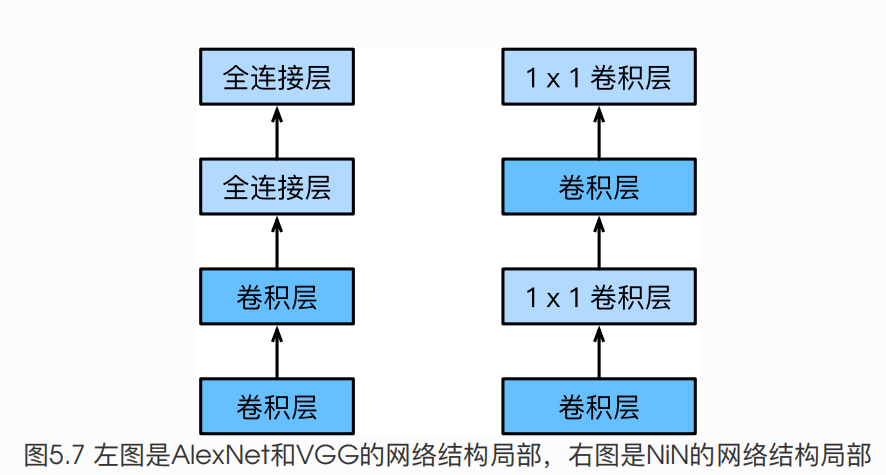

In [45]:
import torch.nn.functional as F
def nin_block(in_channels,out_channels,kernel_size,stride,padding):
    blk = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=1), #  1*1卷积层
        nn.Conv2d(out_channels,out_channels,kernel_size = 1),
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=1),
        nn.ReLU()
    )
    return blk

除使⽤NiN块以外，NiN还有⼀个设计与AlexNet显著不同：<br>
    NiN去掉了AlexNet最后的3个全连接层，取⽽代之地，NiN使⽤了输出通道数等于标签类别数的NiN块，然后使⽤全局平均池化层对每个通道中所有元素求平均并直接⽤于分类。这⾥的全局平均池化层即窗⼝形状等于输⼊空间维形状的平均池化层。<br>
    NiN的这个设计的好处是可以显著减⼩模型参数尺⼨，从⽽缓解过拟合。然⽽该设计有时会造成获得有效模型的训练时间的增加。

In [46]:
class GlobalAvgPool2d(nn.Module):
    #全局平均池化层可以通过将池化窗口形状设置成输入的高和宽实现
    def __init__(self):
        super(GlobalAvgPool2d,self).__init__()
    def forward(self,x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:])

NiN模型

In [47]:
net = nn.Sequential(
    nin_block(1,96,kernel_size=11,stride=4,padding = 0),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nin_block(96,256,kernel_size=5,stride=1,padding = 2),
    nn.MaxPool2d(kernel_size=3,stride = 2),
    nin_block(256,384,kernel_size=3,stride=2,padding= 1),
    nn.MaxPool2d(kernel_size=3,stride = 2),
    nn.Dropout(0.5),
    #标签类别数为10
    nin_block(384,10,kernel_size=3,stride=1,padding=1),
    d2l.GlobalAvgPool2d(),
    d2l.FlattenLayer()
)

In [44]:
X = torch.rand(1, 1, 224, 224)
for name, blk in net.named_children():
     X = blk(X)
     print(name, 'output shape: ', X.shape)

0 output shape:  torch.Size([1, 96, 54, 54])
1 output shape:  torch.Size([1, 96, 26, 26])
2 output shape:  torch.Size([1, 256, 26, 26])
3 output shape:  torch.Size([1, 256, 12, 12])
4 output shape:  torch.Size([1, 384, 6, 6])
5 output shape:  torch.Size([1, 384, 2, 2])
6 output shape:  torch.Size([1, 384, 2, 2])
7 output shape:  torch.Size([1, 10, 2, 2])
8 output shape:  torch.Size([1, 10, 1, 1])
9 output shape:  torch.Size([1, 10])


In [55]:
batch_size = 128
# 如出现“out of memory”的报错信息，可减⼩batch_size或resize
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size,resize=224)
lr, num_epochs = 0.002, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer,device, num_epochs)

training on  cuda
epoch 1, loss 1.3570, train acc 0.502, test acc 0.726, time 97.8 sec
epoch 2, loss 0.6738, train acc 0.760, test acc 0.788, time 98.3 sec
epoch 3, loss 0.5498, train acc 0.798, test acc 0.802, time 98.2 sec
epoch 4, loss 0.5004, train acc 0.816, test acc 0.824, time 98.0 sec
epoch 5, loss 0.4766, train acc 0.823, test acc 0.830, time 98.5 sec


# 5.9 GOOGLENet
## 5.9.1基础卷积块  INCEPTION块


In [17]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
class Inception(nn.Module):
    # c1 -c4为每条线的层的输出通道数
    def __init__(self,in_c,c1,c2,c3,c4):
        
        
        super(Inception,self).__init__()
        #线路1 单1×1卷积层
        self.p1_1 = nn.Conv2d(in_c,c1,kernel_size = 1)
        #线路2 1×1卷积层后接3×3卷积层
        self.p2_1 = nn.Conv2d(in_c,c2[0],kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)  
        # padiing 为1保证了输出图像的高宽不变
        
        # 线路3 1×1卷积层后接5×5卷积层
        self.p3_1 = nn.Conv2d(in_c, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5,padding=2)
        
        # 线路4，3 x 3最⼤池化层后接1 x 1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1,padding=1)
        self.p4_2 = nn.Conv2d(in_c, c4, kernel_size=1)
        
    def forward(self, x):
        
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1) 
        # 在通道维上连结输出

## 5.9.2 GOOGLENet 模型

<p>GoogLeNet跟VGG⼀样，在主体卷积部分中使⽤5个模块（block），每个模块之间使⽤步幅为2的3×3最大池化层来减小输出高宽<br>
最⼤池化层来减⼩输出⾼宽。<br>
<b><i>1 第⼀模块使用⼀个64通道的7×7卷积层。</i></b>
    </p>

In [19]:
b1 = nn.Sequential(
     nn.Conv2d(1, 64, kernel_size=7, stride=2,padding=3),
     nn.ReLU(),
     nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

<b><i>2 第二模块使用两个卷积层 
    <br>首先是643通道的1×1卷积层 
    <br>然后是将通道扩大三倍的3×3卷积层,对应Inception中的第二条线路</i></b>

In [20]:
b2 = nn.Sequential(
    nn.Conv2d(64,64,kernel_size=1),
    nn.Conv2d(64,192,kernel_size=3,padding=1),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

<b><i>3 第三模块串联2个完整的Inception块
    <br>第一个Inception块输出通道数为64+128+32+32 = 256 比例为2：4：1：1。第二、三条线路先分别将输入通道数减少至96/192=1/2 和16/192 = 1/12 再接上第二层卷积层
    <br>第二个Inception块输出通道数增至128+192+96+64 = 480，比例为4：6：3：2。 其中，第二、三条线路先将输入通道减小至128/256和32/256</i></b>

In [21]:
b3 = nn.Sequential(
    Inception(192,64,(96,128),(16,32),32),
    Inception(256,128,(128,192),(32,96),64),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

第四模块更加复杂。它串联了5个Inception块，其输出通道数分别是 192+208+48+64=512、160+224+64+64=512、128+156+64+64=512、112+288+64+64=528 和256+320+128+128=832。这些线路的通道数分配和第三模块中的类似，⾸先含3×3卷积层的第⼆条线路输出最多通道，其次是仅含1×1卷积层的第⼀条线路，之后是含5×5卷积层的第三条线路和含3×3最⼤池化层的第四条线路。其中第⼆、第三条线路都会先按⽐例减⼩通道数。这些⽐例在各
个Inception块中都略有不同。

In [22]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
             Inception(512, 160, (112, 224), (24, 64), 64),
             Inception(512, 128, (128, 256), (24, 64), 64),
             Inception(512, 112, (144, 288), (32, 64), 64),
             Inception(528, 256, (160, 320), (32, 128), 128),
             nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [23]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                     Inception(832, 384, (192, 384), (48, 128), 128),
                     d2l.GlobalAvgPool2d())
net = nn.Sequential(b1, b2, b3, b4, b5,d2l.FlattenLayer(), nn.Linear(1024, 10))

In [24]:
X = torch.rand(1, 1, 96, 96)
for blk in net.children():
    X = blk(X)
    print('output shape: ', X.shape)

output shape:  torch.Size([1, 64, 24, 24])
output shape:  torch.Size([1, 192, 12, 12])
output shape:  torch.Size([1, 480, 6, 6])
output shape:  torch.Size([1, 832, 3, 3])
output shape:  torch.Size([1, 1024, 1, 1])
output shape:  torch.Size([1, 1024])
output shape:  torch.Size([1, 10])


In [25]:
batch_size = 128
# 如出现“out of memory”的报错信息，可减⼩batch_size或resize
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size,
    resize=96)
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer,
    device, num_epochs)

training on  cuda
epoch 1, loss 0.9128, train acc 0.655, test acc 0.824, time 49.9 sec
epoch 2, loss 0.4262, train acc 0.845, test acc 0.849, time 49.9 sec
epoch 3, loss 0.3445, train acc 0.871, test acc 0.871, time 50.1 sec
epoch 4, loss 0.2990, train acc 0.890, test acc 0.895, time 50.0 sec
epoch 5, loss 0.2690, train acc 0.900, test acc 0.885, time 50.2 sec


# 5.10 批量归一化

In [26]:
def batch_norm(is_training,X,gamma,beta,moving_mean,moving_var,eps,momentum):
    #判断当前模式是训练模式还是预测模式
    if not is_training:
        #如果是预测模式下 直接用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean)/torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2,4)
        if len(X.shape) == 2 :
            # 使用全连接层的情况 计算特征维上的均值和方差
            mean = X.mean(dim = 0)
            var = ((X - mean) **2).mean(dim = 0)
        else:
            #使用二维卷积层的情况  计算通道维上（axis = 1）的均值和方差
            #这里需要保持X的形状方便后面做广播运算
            mean = X.mean(dim=0,keepdim =True).mean(dim=2,keepdim=True).mean(dim=3,keepdim=True)
            var = ((X - mean) ** 2).mean(dim=0,keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
        #训练模式下使用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        #更新移动平均的均值和方差
        moving_mean = momentum* moving_mean +(1.0-momentum)*mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y=gamma*X_hat+beta #拉伸和便宜
    return Y,moving_mean,moving_var

接下来，我们⾃定义⼀个 BatchNorm 层。<br>
它保存参与求梯度和迭代的拉伸参数 gamma 和偏移参数 beta ，同时也维护移动平均得到的均值和⽅差，以便能够在模型预测时被使⽤。
<br>BatchNorm 实例
所需指定的 num_features 参数对于全连接层来说应为输出个数，对于卷积层来说则为输出通道数。该实例所需指定的 num_dims 参数对于全连接层和卷积层来说分别为2和4。

In [27]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super(BatchNorm, self).__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成0和1
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 不参与求梯度和迭代的变量，全在内存上初始化成0
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.zeros(shape)
    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var, Module实例的traning属性默
        # 认为true, 调⽤.eval()后设成false
        Y, self.moving_mean, self.moving_var = batch_norm(self.training,X, self.gamma, self.beta, self.moving_mean,self.moving_var, eps=1e-5, momentum=0.9)
        return Y


### 5.10.2.1 使用批量归一化层的LeNet

In [28]:
net = nn.Sequential(
    nn.Conv2d(1,6,5),
    BatchNorm(6,num_dims=4),
    nn.Sigmoid(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(6,16,5),
    nn.Sigmoid(),
    nn.MaxPool2d(2,2),
    d2l.FlattenLayer(),
    nn.Linear(16*4*4,120),
    BatchNorm(120, num_dims=2),
    nn.Sigmoid(),
    nn.Linear(120,84),
    BatchNorm(84,num_dims=2),
    nn.Sigmoid(),
    nn.Linear(84,10)
)

In [29]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer,
    device, num_epochs)

training on  cuda
epoch 1, loss 0.9963, train acc 0.785, test acc 0.444, time 6.6 sec
epoch 2, loss 0.4564, train acc 0.864, test acc 0.600, time 6.7 sec
epoch 3, loss 0.3652, train acc 0.881, test acc 0.579, time 6.7 sec
epoch 4, loss 0.3257, train acc 0.888, test acc 0.503, time 6.7 sec
epoch 5, loss 0.3047, train acc 0.894, test acc 0.751, time 6.9 sec


In [30]:
batch_size = 1024
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer,
    device, num_epochs)

training on  cuda
epoch 1, loss 0.2770, train acc 0.903, test acc 0.711, time 6.5 sec
epoch 2, loss 0.2622, train acc 0.908, test acc 0.329, time 6.3 sec
epoch 3, loss 0.2546, train acc 0.910, test acc 0.729, time 6.4 sec
epoch 4, loss 0.2493, train acc 0.912, test acc 0.705, time 6.4 sec
epoch 5, loss 0.2422, train acc 0.913, test acc 0.824, time 6.6 sec


In [31]:
net[1].gamma.view((-1,)), net[1].beta.view((-1,))

(tensor([1.0728, 0.8296, 1.2879, 1.1250, 1.0230, 1.2766], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([-0.1382,  0.0011,  0.6114, -0.5360,  0.1439,  0.1978], device='cuda:0',
        grad_fn=<ViewBackward>))

# 5.11 残差模块


In [2]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Residual(nn.Module):
    def __init__(self,in_channels,out_channels,use_1conv = False,stride=1):
        super(Residual,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=stride)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        if use_1conv:
            self.conv3 = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride)
            
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self,X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y+X)
    

In [3]:
blk = Residual(3, 3) 
X = torch.rand((4, 3, 6, 6))
blk(X).shape # torch.Size([4, 3, 6, 6])

torch.Size([4, 3, 6, 6])

In [4]:
blk = Residual(3, 6, use_1conv=True, stride=2)
blk(X).shape # torch.Size([4, 6, 3, 3])

torch.Size([4, 6, 3, 3])

In [5]:
net = nn.Sequential(
    nn.Conv2d(1,64,kernel_size = 7,stride =2,padding = 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding =1)
)

In [6]:
def resnet_block(in_channels,out_channels,num_residuals,first_block = False):
    if first_block:
        assert in_channels == out_channels #第一个模块的通道数同输入通道一致
    blk = []
    for i in range(num_residuals):
        if i==0 and not first_block:  #如果i=0且不是首个模块 
            blk.append(Residual(in_channels,out_channels,use_1conv=True,stride=2))
        else:  # 如果i不等于0 或者是第一一个模块
            blk.append(Residual(out_channels,out_channels))
        return nn.Sequential(*blk)

In [7]:
net.add_module("resnet_block1", resnet_block(64, 64, 2,first_block=True))
net.add_module("resnet_block2", resnet_block(64, 128, 2))
net.add_module("resnet_block3", resnet_block(128, 256, 2))
net.add_module("resnet_block4", resnet_block(256, 512, 2))

In [8]:
net.add_module("global_avg_pool", d2l.GlobalAvgPool2d()) 
#GlobalAvgPool2d的输出: (Batch, 512, 1, 1)
net.add_module("fc", nn.Sequential(d2l.FlattenLayer(),nn.Linear(512, 10)))

In [9]:
X = torch.rand((1, 1, 224, 224))
for name, layer in net.named_children():
    X = layer(X)
    print(name, ' output shape:\t', X.shape)

0  output shape:	 torch.Size([1, 64, 112, 112])
1  output shape:	 torch.Size([1, 64, 112, 112])
2  output shape:	 torch.Size([1, 64, 112, 112])
3  output shape:	 torch.Size([1, 64, 56, 56])
resnet_block1  output shape:	 torch.Size([1, 64, 56, 56])
resnet_block2  output shape:	 torch.Size([1, 128, 28, 28])
resnet_block3  output shape:	 torch.Size([1, 256, 14, 14])
resnet_block4  output shape:	 torch.Size([1, 512, 7, 7])
global_avg_pool  output shape:	 torch.Size([1, 512, 1, 1])
fc  output shape:	 torch.Size([1, 10])


In [10]:
net1 = nn.Sequential(
    nn.Conv2d(1,64,kernel_size = 7,stride =2,padding = 3),
    nn.MaxPool2d(kernel_size=3,stride=2,padding =1))

In [11]:
X2 = torch.rand(1,1,224,224)
X2= net1(X2)
X2.shape

torch.Size([1, 64, 56, 56])

In [12]:
batch_size = 256
# 如出现“out of memory”的报错信息，可减⼩batch_size或resize
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size,resize=96)
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer,device, num_epochs)

D:\anaconda3\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


training on  cuda
epoch 1, loss 0.3605, train acc 0.869, test acc 0.902, time 38.3 sec
epoch 2, loss 0.2299, train acc 0.915, test acc 0.911, time 33.0 sec
epoch 3, loss 0.1883, train acc 0.929, test acc 0.883, time 32.9 sec
epoch 4, loss 0.1587, train acc 0.941, test acc 0.914, time 33.1 sec
epoch 5, loss 0.1342, train acc 0.951, test acc 0.921, time 33.1 sec


# 5.12 稠密连接网络 DENSENET
与ResNet的主要区别在于，DenseNet⾥模块的输出不是像ResNet那样和模块 的输出相加，⽽是在通道维上连结。这样模块 的输出可以直接传⼊模块后⾯的层。在这个设计⾥，模块 直接跟模块 后⾯的所有层连接在了⼀起。这也是它被称
为“稠密连接”的原因

In [16]:
# DenseNet使⽤了ResNet改良版的“批量归⼀化、激活和卷积”结构
def conv_block(in_channels,out_channels):
    blk = nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels,out_channels,kernel_size = 3,padding = 1))
    return blk

In [17]:
# 稠密块由多个 conv_block 组成，每块使⽤相同的输出通道数。
# 但在前向计算时，我们将每块的输⼊和输出在通道维上连结。
class DenseBlock(nn.Module):
    def __init__(self,num_convs,in_channels,out_channels):
        super(DenseBlock,self).__init__()
        net = []
        for i in range(num_convs):
            in_c = in_channels + i*out_channels
            net.append(conv_block(in_c,out_channels))
        self.net = nn.ModuleList(net)
        self.out_channels = in_channels + num_convs*out_channels
        #计算输出通道数
        
    def forward(self,x):
        for blk in self.net:
            y= blk(x)
            x = torch.cat((x,y),dim = 1) 
        return x

在下⾯的例⼦中，我们定义⼀个有2个输出通道数为10的卷积块。使⽤通道数为3的输⼊时，我们会得到通道数为3+2×10 = 23的输出。卷积块的通道数控制了输出通道数相对于输⼊通道数的增⻓，因此
也被称为增⻓率（growth rate）。


In [18]:
blk = DenseBlock(2,3,10)
X = torch.rand(4,3,8,8)
Y= blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

In [22]:
# 过渡层用来减少模型的通道数，并使得高和宽减半
def transition_block(in_channels,out_channels):
    blk = nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels,out_channels,kernel_size =1),
        nn.AvgPool2d(kernel_size=2,stride=2)
    )
    return blk

In [23]:
blk2 = transition_block(23, 10)
blk2(Y).shape # torch.Size([4, 10, 4, 4])

torch.Size([4, 10, 4, 4])

In [24]:
# 构造DENSENET模型
net = nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding = 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

类似于ResNet接下来使⽤的4个残差块，DenseNet使⽤的是4个稠密块。同ResNet⼀样，我们可以设
置每个稠密块使⽤多少个卷积层。这⾥我们设成4，从⽽与上⼀节的ResNet-18保持⼀致。稠密块⾥的卷
积层通道数（即增⻓率）设为32，所以每个稠密块将增加128个通道。

In [ ]:
num_channels, growth_rate = 64, 32 # num_channels为当前的通道数
num_convs_in_dense_blocks = [4, 4, 4, 4]

for i ,num_convs in enumerate(num_convs_in_dense_blocks):
    DB = DenseBlock(num_convs,num_channels,growth_rate)
    net.add_module("DenseBlock_%d" % i,DB)
    # 上一个稠密块的输出通道数
    num_channels = DB.out_channels
    #在稠密块之间加入通道数减半的过渡层
    if i != len(num_convs_in_dense_blocks) - 1:
        net.add_module("transition_block_%d" % i,transition_block(num_channels,))